# 1. Preparations

Before start, make sure that you choose
* Runtime Type = Python 3
* Hardware Accelerator = GPU

in the **Runtime** menu -> **Change runtime type**

Then, we set up the envrironment.

* install bmf
* install requirement python module
* install wurlitzer and load_ext for outputing logs of c extension module

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1vvUssyc8GC8SPzVdYwRwKc2OvyKGY-Px/view?usp=sharing
!pip install BabitMF basicsr==1.4.2 realesrgan torchvision==0.15.2
!pip install wurlitzer
%load_ext wurlitzer

Downloading...
From: https://drive.google.com/uc?id=1B2iUlDEUuled09IFYE3C2mD1Rx1LEmd6
To: /content/bmf-3.0.0-cp310-none-linux_x86_64.whl
100% 98.3M/98.3M [00:03<00:00, 31.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vvUssyc8GC8SPzVdYwRwKc2OvyKGY-Px
To: /content/bbb_360_20s.mp4
100% 1.13M/1.13M [00:00<00:00, 151MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./bmf-3.0.0-cp310-none-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 7.0 MB/s eta 0:

# 2 source code

## **enhance_module**

We implemente the inference process of this project [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN) as a BMF module

import and some util functions:

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# This code is based on the implementation from https://github.com/xinntao/Real-ESRGAN

from basicsr.archs.rrdbnet_arch import RRDBNet
from basicsr.utils.download_util import load_file_from_url

from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact

from bmf import Module, Log, Timestamp, ProcessResult, LogLevel, Packet, VideoFrame
from bmf.lib._bmf.sdk import ffmpeg

from bmf import hmp as mp
import numpy as np

import os


def load_model():
    model = SRVGGNetCompact(
        num_in_ch=3,
        num_out_ch=3,
        num_feat=64,
        num_conv=16,
        upscale=4,
        act_type="prelu",
    )
    netscale = 4
    file_url = [
        "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth"
    ]
    return model, netscale, file_url


def prepare_model(model_name, file_url):
    model_path = os.path.join("weights", model_name + ".pth")
    if not os.path.isfile(model_path):
        ROOT_DIR = "/content"
        for url in file_url:
            # model_path will be updated
            model_path = load_file_from_url(
                url=url,
                model_dir=os.path.join(ROOT_DIR, "weights"),
                progress=True,
                file_name=None,
            )
    return model_path

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


This module retrieves BMF VideoFrames from the upstream module, then uses the functions provided by the BMF framework to convert VideoFrame to RGB24 format, and then converts it to a numpy array. The numpy array is then sent to the inference object for super-resolution processing. The inference result is a RGB24 frame, which is also a numpy array. The result is then converted back to BMF VideoFrame and sent to the downstream module. This is a typical BMF module processing flow.

In [3]:
class EnhanceModule(Module):
    def __init__(self, node=None, option=None):
        self._node = node
        if not option:
            Log.log_node(LogLevel.ERROR, self._node, "no option")
            return

        tile = option.get("tile", 0)
        tile_pad = option.get("tile_pad", 10)
        pre_pad = option.get("pre_pad", 10)
        fp32 = option.get("fp32", False)
        gpu_id = option.get("gpu_id", 0)

        self.output_scale = option.get("output_scale", None)

        model, netscale, file_url = load_model()
        model_name = "realesr-animevideov3"  # x4 VGG-style model (XS size)
        model_path = prepare_model(model_name, file_url)

        self.upsampler = RealESRGANer(
            scale=netscale,
            model_path=model_path,
            dni_weight=None,
            model=model,
            tile=tile,
            tile_pad=tile_pad,
            pre_pad=pre_pad,
            half=not fp32,
            gpu_id=gpu_id,
        )
        self.process_num = 0

    def process(self, task):
        output_queue = task.get_outputs().get(0, None)
        input_queue = task.get_inputs().get(0, None)

        while not input_queue.empty():
            pkt = input_queue.get()
            # process EOS
            if pkt.timestamp == Timestamp.EOF:
                Log.log_node(LogLevel.INFO, task.get_node(), "Receive EOF")
                if output_queue is not None:
                    output_queue.put(Packet.generate_eof_packet())
                task.timestamp = Timestamp.DONE
                return ProcessResult.OK

            video_frame = pkt.get(VideoFrame)
            # use ffmpeg
            frame = ffmpeg.reformat(video_frame, "rgb24").frame().plane(0).numpy()

            output, _ = self.upsampler.enhance(frame, self.output_scale)
            Log.log_node(
                LogLevel.DEBUG,
                self._node,
                "enhance output shape: ",
                output.shape,
                " flags: ",
                output.flags,
            )
            self.process_num += 1
            if self.process_num % 10 == 0:
                Log.log_node(LogLevel.INFO, self._node, "process num: ", self.process_num)
            output = np.ascontiguousarray(output)
            rgbformat = mp.PixelInfo(mp.kPF_RGB24)
            image = mp.Frame(mp.from_numpy(output), rgbformat)

            output_frame = VideoFrame(image)
            Log.log_node(LogLevel.DEBUG, self._node, "output video frame")

            output_frame.pts = video_frame.pts
            output_frame.time_base = video_frame.time_base
            output_pkt = Packet(output_frame)
            output_pkt.timestamp = pkt.timestamp
            if output_queue is not None:
                output_queue.put(output_pkt)

        return ProcessResult.OK

## **compose_module**
We implement another module which named compose_module to overlay and display the super-resolution results and the original video. 

This module processes two VideoFrames from the upstream module at the same time, which are the original video frame and the super-resolution frame. Then, it uses OpenCV to combine them into one frame and outputs it to the downstream module. The BMF framework provides an input manager called 'framesync', which can synchronize multiple inputs to a module. It only needs to be specified when creating the module.

In [4]:
class Compositor:
    def __init__(self):
        self.slide_step = 5
        self.line_width = 10
        self.frame_width = 0
        self.frame_num = 0

    def merge(self, img_left, img_right, x_coord):
        img_out = np.copy(img_left)
        img_out[:, x_coord:, :] = img_right[:, x_coord:, :]

        # white line
        img_out[:, x_coord : x_coord + self.line_width, :] = 255

        return img_out

    def compose(self, img_left, img_right):
        if self.frame_width == 0:
            self.frame_width = img_left.shape[1]

        remainder = (self.frame_num * self.slide_step) % (2 * self.frame_width)
        x_coord = min(remainder, 2 * self.frame_width - remainder)

        out = self.merge(img_left, img_right, x_coord)

        self.frame_num += 1

        return out


class CompositionModule(Module):
    def __init__(self, node=None, option=None):
        self._node = node
        self.compositor = Compositor()

    def process(self, task):
        output_queue = task.get_outputs().get(0, None)

        current_pts = None
        current_timestamp = 0
        current_timebase = None

        # collect frames
        frame_list = []
        for (index, input_packets) in task.get_inputs().items():
            Log.log_node(
                LogLevel.DEBUG,
                self._node,
                "process input index: ",
                index,
            )

            num = 0
            while not input_packets.empty():
                pkt = input_packets.get()
                num += 1
                # process EOS
                if pkt.timestamp == Timestamp.EOF:
                    Log.log_node(
                        LogLevel.INFO, task.get_node(), "Receive EOF................."
                    )
                    if output_queue is not None:
                        output_queue.put(Packet.generate_eof_packet())
                    task.timestamp = Timestamp.DONE
                    return ProcessResult.OK

                frame = pkt.get(VideoFrame)

                # record
                if current_pts is None:
                    current_pts = frame.pts
                    current_timebase = frame.time_base
                    current_timestamp = pkt.timestamp

                rgb_frame = ffmpeg.reformat(frame, "rgb24").frame().plane(0).numpy()

                Log.log_node(
                    LogLevel.DEBUG,
                    self._node,
                    "index:",
                    index,
                    "get frame pts: ",
                    frame.pts,
                )
                frame_list.append(rgb_frame)

            Log.log_node(
                LogLevel.DEBUG, self._node, "index:", index, "get frame num:", num
            )

        if len(frame_list) != 2:
            Log.log_node(
                LogLevel.WARNING,
                self._node,
                "frame list num incorrect, check framesync input",
            )
            return ProcessResult.OK

        out = self.compositor.compose(frame_list[0], frame_list[1])

        rgbformat = mp.PixelInfo(mp.kPF_RGB24)
        image = mp.Frame(mp.from_numpy(out), rgbformat)
        output_frame = VideoFrame(image)
        output_frame.pts = current_pts
        output_frame.time_base = current_timebase
        output_pkt = Packet(output_frame)
        output_pkt.timestamp = current_timestamp

        # output index 0 for test
        if output_queue is not None:
            output_queue.put(output_pkt)

        return ProcessResult.OK

## **main program**

We create module instances and connect those modules into a pipeline through a main program, run it, and finally obtain the results.

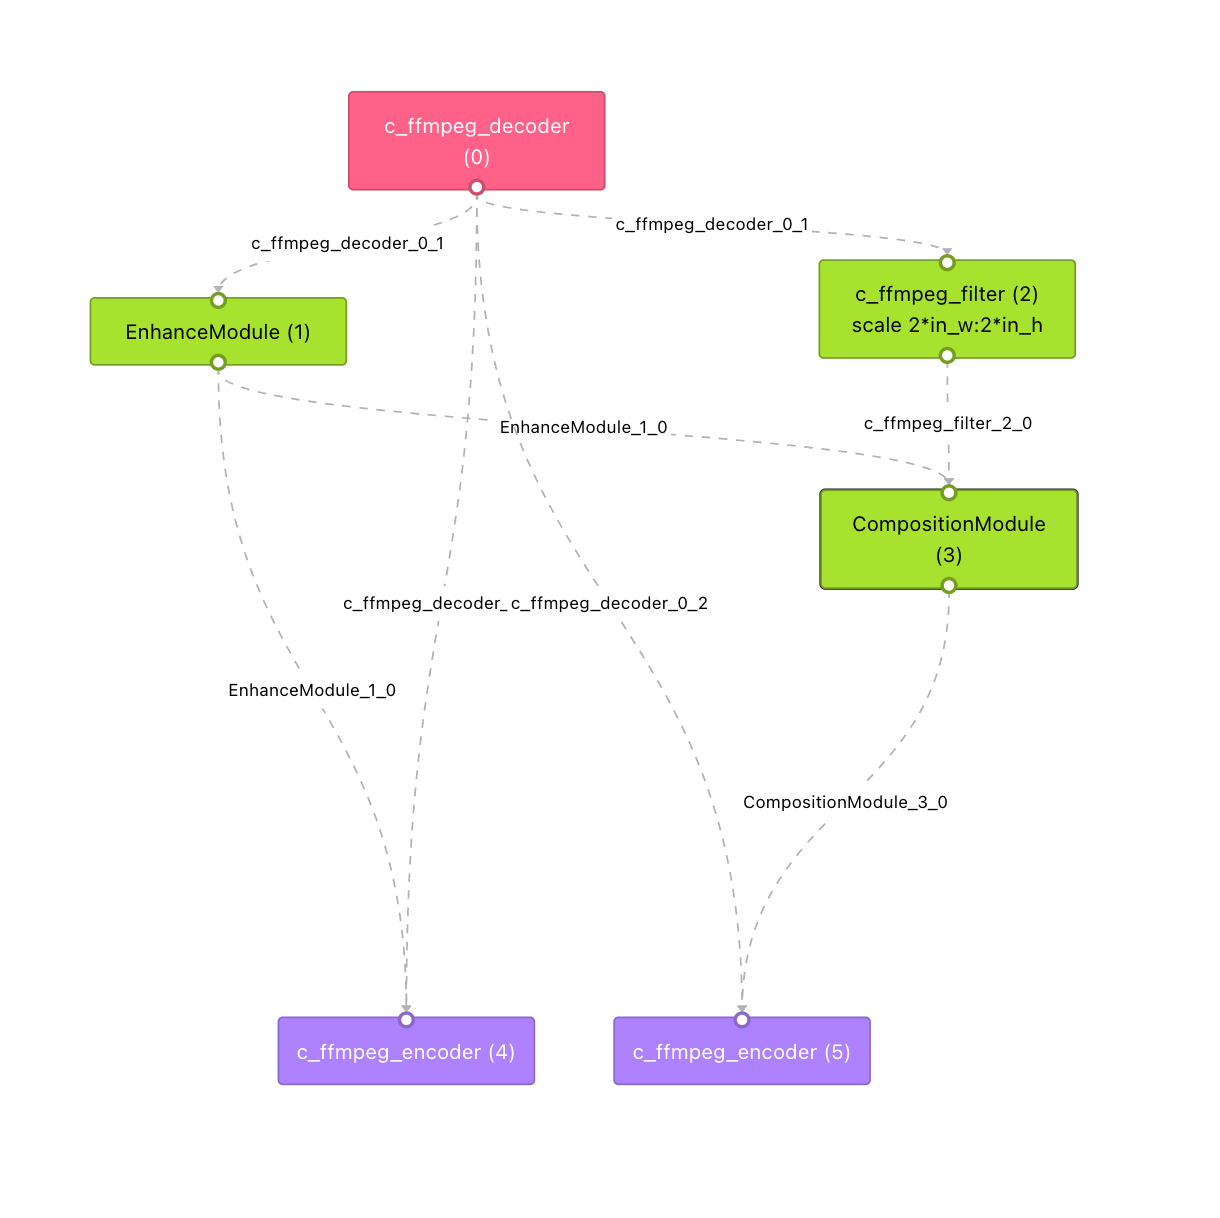

In [5]:
Log.set_log_level(LogLevel.INFO)

In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

input_file = "bbb_360_20s.mp4"
output_file = "output.mp4"
output_compose_file = "output_compose.mp4"

import bmf


def run():
    graph = bmf.graph()
    video = graph.decode(
        {
            "input_path": input_file,
        }
    )

    enhance = bmf.module(
        [video["video"]],
        "EnhanceModule",
        option={"fp32": True, "output_scale": 2},
        entry="__main__.EnhanceModule",
        input_manager="immediate",
    )

    origin_video_scale = video["video"].scale("2*in_w:2*in_h")

    com = bmf.module(
        [enhance[0], origin_video_scale],
        "CompositionModule",
        entry="__main__.CompositionModule",
        input_manager="framesync",
    )

    bmf.encode(
        enhance[0],
        video["audio"],
        {
            "video_params": {"g": "50", "preset": "veryfast", "bf": 0, "vsync":"vfr", "max_fr":30},
            "audio_params": {"sample_rate": 44100, "codec": "aac"},
            "loglevel": "info",
            "output_path": output_file,
        },
    )

    bmf.encode(
        com[0],
        video["audio"],
        {
            "video_params": {"g": "50", "preset": "veryfast", "bf": 0, "vsync":"vfr", "max_fr":30},
            "audio_params": {"sample_rate": 44100, "codec": "aac"},
            "loglevel": "info",
            "output_path": output_compose_file,
        },
    )
    graph.run()


if __name__ == "__main__":
    run()

{
    "input_streams": [],
    "output_streams": [],
    "nodes": [
        {
            "module_info": {
                "name": "c_ffmpeg_decoder",
                "type": "",
                "path": "",
                "entry": ""
            },
            "meta_info": {
                "premodule_id": -1,
                "callback_binding": []
            },
            "option": {
                "input_path": "bbb_360_20s.mp4"
            },
            "input_streams": [],
            "output_streams": [
                {
                    "identifier": "video:c_ffmpeg_decoder_0_1",
                    "stream_alias": ""
                },
                {
                    "identifier": "audio:c_ffmpeg_decoder_0_2",
                    "stream_alias": ""
                }
            ],
            "input_manager": "immediate",
            "scheduler": 0,
            "alias": "",
            "id": 0
        },
        {
            "module_info": {
                "name"

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'bbb_360_20s.mp4':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf59.27.100
  Duration: 00:00:20.13, start: 0.008005, bitrate: 449 kb/s
    Stream #0:0(und): Video: h264 (High) (avc1 / 0x31637661), yuv420p(tv, bt709), 640x360 [SAR 1:1 DAR 16:9], 321 kb/s, 30 fps, 30 tbr, 15360 tbn, 60 tbc (default)
    Metadata:
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/04/2022.
      encoder         : Lavc59.37.100 libx264
    Stream #0:1(und): Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      handler_name    : ISO Media file produced by Google Inc. Created on: 09/04/2022.


[2023-06-02 02:48:11.864] [info] c++ module constructed
[2023-06-02 02:48:11.869] [info] debug module_name: EnhanceModule type:  path:  entry: __main__.EnhanceModule
[2023-06-02 02:48:11.869] [info] Module info EnhanceModule python __main__.EnhanceModule /content
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth" to /content/weights/realesr-animevideov3.pth



100%|██████████| 2.39M/2.39M [00:00<00:00, 188MB/s]


[2023-06-02 02:48:16.759] [info] debug module_name: c_ffmpeg_filter type:  path:  entry: 
[2023-06-02 02:48:16.759] [info] c_ffmpeg_filter c++ /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so libbuiltin_modules.CFFFilter
[2023-06-02 02:48:16.759] [info] Module info c_ffmpeg_filter c++ libbuiltin_modules.CFFFilter /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so
[2023-06-02 02:48:16.759] [info] Constructing c++ module
[2023-06-02 02:48:16.760] [info] c++ module constructed
[2023-06-02 02:48:16.760] [info] debug module_name: CompositionModule type:  path:  entry: __main__.CompositionModule
[2023-06-02 02:48:16.760] [info] Module info CompositionModule python __main__.CompositionModule /content
[2023-06-02 02:48:16.763] [info] debug module_name: c_ffmpeg_encoder type:  path:  entry: 
[2023-06-02 02:48:16.763] [info] c_ffmpeg_encoder c++ /usr/local/lib/python3.10/dist-packages/bmf/lib/libbuiltin_modules.so libbuiltin_modules.CFFEncoder
[2023-06-02 

[libx264 @ 0x7fb31026bd00] ignoring invalid SAR: 0/0
[libx264 @ 0x7fb31026bd00] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x7fb31026bd00] profile High, level 3.1
[libx264 @ 0x7fb31026bd00] 264 - core 155 r2917 0a84d98 - H.264/MPEG-4 AVC codec - Copyleft 2003-2018 - http://www.videolan.org/x264.html - options: cabac=1 ref=1 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=2 psy=1 psy_rd=1.00:0.00 mixed_ref=0 me_range=16 chroma_me=1 trellis=0 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=0 threads=3 lookahead_threads=1 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=0 weightp=1 keyint=50 keyint_min=5 scenecut=40 intra_refresh=0 rc_lookahead=10 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to 'output.mp4':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Audio: aac (LC) (mp4a / 0x6134706D), 44100 Hz, stereo, fltp, 128 kb/s
    S

[2023-06-02 02:50:54.633] [info] node id:0 decode flushing
[2023-06-02 02:50:54.633] [info] node id:0 Process node end
[2023-06-02 02:50:54.634] [info] node id:0 close node
[2023-06-02 02:50:54.634] [info] node 0 close report, closed count: 1
[2023-06-02 02:50:54.634] [info] node id:1 eof received
[2023-06-02 02:50:54.634] [info] node id:1 eof processed, remove node from scheduler
[2023-06-02 02:50:54.634] [info] node id:2 eof received
[2023-06-02 02:50:54.634] [info] node id:2 eof processed, remove node from scheduler
[2023-06-02 02:50:54.634] [info] node id:4 eof received
[2023-06-02 02:50:54.634] [info] node id:4 eof processed, remove node from scheduler
[2023-06-02 02:50:54.634] [info] node id:5 eof received
[2023-06-02 02:50:54.634] [info] node id:5 eof processed, remove node from scheduler
[2023-06-02 02:50:54.634] [info] node id:1 process eof, add node to scheduler


INFO:main:149.648973 -- (1) -- process num:  590
INFO:main:149.650781 -- (1) -- Receive EOF


[2023-06-02 02:50:55.535] [info] node id:1 Process node end
[2023-06-02 02:50:55.535] [info] node id:1 close node
[2023-06-02 02:50:55.535] [info] node 1 close report, closed count: 2
[2023-06-02 02:50:55.535] [info] node id:3 eof received
[2023-06-02 02:50:55.536] [info] node id:4 eof received
[2023-06-02 02:50:55.536] [info] node id:4 eof processed, remove node from scheduler
[2023-06-02 02:50:55.536] [info] node id:4 process eof, add node to scheduler
[2023-06-02 02:50:55.536] [info] node id:2 process eof, add node to scheduler
[2023-06-02 02:50:55.543] [info] node id:2 Process node end
[2023-06-02 02:50:55.543] [info] node id:2 close node
[2023-06-02 02:50:55.543] [info] node 2 close report, closed count: 3
[2023-06-02 02:50:55.543] [info] node id:3 eof received
[2023-06-02 02:50:55.583] [info] node id:3 eof processed, remove node from scheduler
[2023-06-02 02:50:55.583] [info] node id:3 eof processed, remove node from scheduler
[2023-06-02 02:50:55.622] [info] node id:3 process eo

INFO:main:149.746040 -- (3) -- Receive EOF.................


[2023-06-02 02:50:55.635] [info] node id:3 Process node end
[2023-06-02 02:50:55.635] [info] node id:3 close node
[2023-06-02 02:50:55.635] [info] node 3 close report, closed count: 4
[2023-06-02 02:50:55.635] [info] node id:5 eof received
[2023-06-02 02:50:55.635] [info] node id:5 eof processed, remove node from scheduler
[2023-06-02 02:50:55.769] [info] node id:4 Process node end


[libx264 @ 0x7fb31026bd00] frame I:14    Avg QP:18.71  size: 59082
[libx264 @ 0x7fb31026bd00] frame P:576   Avg QP:22.48  size:  2176
[libx264 @ 0x7fb31026bd00] mb I  I16..4: 17.2% 41.3% 41.5%
[libx264 @ 0x7fb31026bd00] mb P  I16..4:  0.9%  1.9%  0.2%  P16..4:  6.2%  2.7%  1.1%  0.0%  0.0%    skip:86.9%
[libx264 @ 0x7fb31026bd00] 8x8 transform intra:53.4% inter:34.7%
[libx264 @ 0x7fb31026bd00] coded y,uvDC,uvAC intra: 52.2% 57.3% 25.5% inter: 1.7% 2.6% 0.1%
[libx264 @ 0x7fb31026bd00] i16 v,h,dc,p: 42% 25%  8% 25%
[libx264 @ 0x7fb31026bd00] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 20% 22% 22%  6%  6%  7%  6%  6%  6%
[libx264 @ 0x7fb31026bd00] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 29% 15%  9%  6%  8% 10%  7%  9%  6%
[libx264 @ 0x7fb31026bd00] i8c dc,h,v,p: 43% 31% 18%  9%
[libx264 @ 0x7fb31026bd00] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 0x7fb31026bd00] kb/s:841.92


[2023-06-02 02:50:55.771] [info] node id:4 close node
[2023-06-02 02:50:55.771] [info] node 4 close report, closed count: 5


[aac @ 0x7fb3100021c0] Qavg: 255.798


[2023-06-02 02:50:55.839] [info] node id:5 process eof, add node to scheduler
[2023-06-02 02:50:56.013] [info] node id:5 Process node end


[libx264 @ 0x7fb3107ffac0] frame I:14    Avg QP:18.64  size: 55689
[libx264 @ 0x7fb3107ffac0] frame P:576   Avg QP:24.60  size:  2620
[libx264 @ 0x7fb3107ffac0] mb I  I16..4: 18.0% 40.1% 41.9%
[libx264 @ 0x7fb3107ffac0] mb P  I16..4:  1.4%  2.1%  0.3%  P16..4:  6.9%  3.3%  1.3%  0.0%  0.0%    skip:84.7%
[libx264 @ 0x7fb3107ffac0] 8x8 transform intra:49.9% inter:37.3%
[libx264 @ 0x7fb3107ffac0] coded y,uvDC,uvAC intra: 52.8% 60.3% 24.7% inter: 1.9% 3.2% 0.3%
[libx264 @ 0x7fb3107ffac0] i16 v,h,dc,p: 54% 23%  9% 14%
[libx264 @ 0x7fb3107ffac0] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 21% 23% 19%  5%  6%  7%  6%  7%  6%
[libx264 @ 0x7fb3107ffac0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 31% 16%  9%  5%  8%  9%  7%  9%  6%
[libx264 @ 0x7fb3107ffac0] i8c dc,h,v,p: 38% 27% 27%  8%
[libx264 @ 0x7fb3107ffac0] Weighted P-Frames: Y:0.0% UV:0.0%
[libx264 @ 0x7fb3107ffac0] kb/s:926.31


[2023-06-02 02:50:56.016] [info] node id:5 close node
[2023-06-02 02:50:56.016] [info] node 5 close report, closed count: 6
[2023-06-02 02:50:56.016] [info] schedule queue 0 start to join thread
[2023-06-02 02:50:56.016] [info] schedule queue 0 thread quit
[2023-06-02 02:50:56.017] [info] schedule queue 0 closed
[2023-06-02 02:50:56.017] [info] schedule queue 1 start to join thread


[aac @ 0x7fb31012dc80] Qavg: 255.798


[2023-06-02 02:50:56.019] [info] schedule queue 1 thread quit
[2023-06-02 02:50:56.020] [info] schedule queue 1 closed
[2023-06-02 02:50:56.020] [info] all scheduling threads were joint


# 3 Visulize output video

In [ ]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 800):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

# input video
show_video('output_compose.mp4')

Output hidden; open in https://colab.research.google.com to view.